In [1]:
""" Training RNNs to learn addition
    Sequences: Simple addition ( + X + Y =), 4 inputs (A, B, C, D), 16 unique sequences
    Curricula: 
             Primitive: base simple addition sequences + primitive sequences (+A=, +B= , ...)
             Balanced: base simple addition sequences + balancing simple addition sequences instead of primitives
    Trains RNNs on Balanced and Primitive curricula with N base sequences (for N in range 1-8), 
    and tests the trained RNNs on the remaining 16 - N.
    Compares RNN generalization performance with two metrics: generate_primitives(i) R sequares, (ii) RMSE"""

' Training RNNs to learn addition\n    Sequences: Simple addition ( + X + Y =), 4 inputs (A, B, C, D), 16 unique sequences\n    Curricula: \n             Primitive: base simple addition sequences + primitive sequences (+A=, +B= , ...)\n             Balanced: base simple addition sequences + balancing simple addition sequences instead of primitives\n    Trains RNNs on Balanced and Primitive curricula with N base sequences (for N in range 1-8), \n    and tests the trained RNNs on the remaining 16 - N.\n    Compares RNN generalization performance with two metrics: generate_primitives(i) R sequares, (ii) RMSE'

In [2]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

from cryptic_rnn import *

# Functions

In [3]:
def run_exp(cue_dict, j):
    
    """ Trains RNNs for a given training set size in balanced and primitive curricula, using paired initialization of RNN
    Args:
       cue_dict: dictionary of symbols and their integer values
       j: number of base training trials
    Returns
       dictionary with cue_dict, test sequences, losses and accuracies for the RNNs.
    """
    
    #### randomly assign integers to symbols
    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    #### generate train and test sequences
    # all seqs
    trial_list = []
    for s in range(1, len(all_syms)+1):
        trial_list += (generate_pairs(ops, all_syms, cue_dict, s))
    # generate primitive and balancing seqs
    primitives = generate_pos_primitives(all_syms, cue_dict)
    balanced_prims = generate_complex_primitives(ops, all_syms, cue_dict)
    train_trials = [trial for trial in trial_list if trial not in balanced_prims] # remove any seqs in balanced set
    # curricula seqs
    basic_train = train_trials[:j] # select first j seqs
    trainseqs_b = basic_train + balanced_prims # balanced curriculum
    trainseqs_p = basic_train + primitives # primitive curriculum
    # test set
    testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict) 
    testseqs = [t for t in testseqs if t not in trainseqs_b]

    ### load sequence data
    # test set 
    testseqs = change_dict(testseqs, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    # balanced training
    tseqs = change_dict(trainseqs_b, cue_dict)
    train_inputs = convert_seq2inputs(tseqs, num_classes=num_classes, seq_len=5)
    trainset_b = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    # primitive training
    tseqs = change_dict(trainseqs_p, cue_dict)
    train_inputs = convert_seq2inputs(tseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
        
    ### Paired initialization of models
    model_b = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model_b)
    criterion = nn.MSELoss()
    
    ### run primitive training RNN
    # balanced
    optimizer = torch.optim.Adam(model_b.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model_b,optimizer,criterion, trainset_b, [trainset_b, testset], epochs, hidden_size)
    # primitive
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
    return {'cue_dict':cue_dict,'test': testset,
           'loss_b':loss1, 'acc_b':acc1, 'mod_b': model_b,\
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def run_plot(cue_dict, j):
    
    """ Trains RNNs in parallel for num_sims simulations
    Args:
       cue_dict: dictionary of symbols and their integer values
       j: number of base training trials
    Returns: dictionary with combined simulation results
          mods_b: list of Balanced curricula models
          mods_p: list of Primitive curricula models
          res: list of result dictionaries of run_exp
          tests: test sets for each model pair
          cue_dicts: cue_dict for each model pair
          acc_df: accuracy data frame for each model pair
    """
    
    # run and time set of simulations
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(cue_dict, j) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    # extract values from list of results
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    # balanced results
    losses_b = np.hstack([r['loss_b'] for r in res])
    acc_train_b = np.array([r['acc_b'][:,0] for r in res]).T
    acc_test_b = np.array([r['acc_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]
    # primitive results
    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]

    # correlation between model predictions and ground truth
    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =False)
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = False)
    # r squared scores for model predicitons
    print('B: ', r2_b)
    print('P: ', r2_p)
    # data frame with train and test accuracies for each model - each row corresponds to a jointly initialized model pair
    acc_df = pd.DataFrame({'acc_train_b': acc_train_b[-1,:], 'acc_test_b': acc_test_b[-1,:],\
                           'acc_train_p': acc_test_p[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    return {'mods_b':mods_b, 'mods_p':mods_p, \
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }

def input_frac_run(num_inputs, max_train_trials):
#      """ Trains sets of RNNs for a range of training set sizes
#     Args:
#        num_inputs: number of symbols to incude in sequences
#        max_train_trials: max number of base training trials
#     Returns: list of results, where each element is the result for the number of base seqs in the training set
#     """
    # select input symbols
    all_syms = total_syms[:num_inputs]
    # assign integers to each value
    input_vals = random.sample(all_input_vals,num_inputs)  # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    # for each number of base seqs, train RNNs on this training set
    reses = []
    for j in range(1, max_train_trials+1):
        print('##################\nnumber of train trials: ',j)      
        res_j = run_plot(cue_dict, j)
        reses.append(res_j)      
    
    return reses

In [4]:
## plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## RNN params

In [5]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## Sequences

In [6]:
ops = '+' # addition operation

num_inputs = 4 # number of input symbols
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'] # all input symbols
all_syms = total_syms[:num_inputs] # select set of input symbols

# randomly select values for each input 
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]  

## Run/Load/Save

In [7]:
num_sims= 10 # number of simulations
epochs = 1000 # number of epochs
# run 
res = input_frac_run(4, 8)

##################
number of train trials:  1


100%|██████████| 10/10 [00:00<00:00, 32.29it/s]


run time:  0.9725656151771546
B:  0.44950923989690295
P:  0.29685531591724845
##################
number of train trials:  2


100%|██████████| 10/10 [00:00<00:00, 6057.63it/s]


run time:  0.9294932007789611
B:  0.33196897153745464
P:  0.8563853952555177
##################
number of train trials:  3


100%|██████████| 10/10 [00:00<00:00, 7835.43it/s]


run time:  1.033841117223104
B:  0.805681285146487
P:  0.9681944935085456
##################
number of train trials:  4


100%|██████████| 10/10 [00:00<00:00, 9653.17it/s]


run time:  1.143058168888092
B:  0.813160910726981
P:  0.9828318912622206
##################
number of train trials:  5


100%|██████████| 10/10 [00:00<00:00, 4029.11it/s]


run time:  1.1917643507321676
B:  0.9922468613776128
P:  0.9848664276678671
##################
number of train trials:  6


100%|██████████| 10/10 [00:00<00:00, 6862.41it/s]


run time:  1.298024598757426
B:  0.9990604054268221
P:  0.9708875125383196
##################
number of train trials:  7


100%|██████████| 10/10 [00:00<00:00, 7012.71it/s]


run time:  1.3598281860351562
B:  0.9996218240224378
P:  0.9967038279729865
##################
number of train trials:  8


100%|██████████| 10/10 [00:00<00:00, 8635.59it/s]


run time:  1.4520206848780315
B:  0.9989823496874323
P:  0.9984937730994075


In [8]:
# save
savedir = 'Results/4_inputs'
with open(savedir, 'wb') as f:
    pickle.dump(res, f)
f.close()

In [9]:
# load
savedir = 'Results/4_inputs'
with open(savedir, 'rb') as f:
    res = pickle.load(f)


# MSE Loss

plot RMSE loss against number of base training trials for Balanced vs Primitive curriculum

In [10]:
# calculate MSE loss for each training set size, for Balanced and Primitive curricula
lp = []
lb = []
for res_n in res:
    calc_loss = extract_MSELoss(res_n)
    lb.append(calc_loss['mse_b'])
    lp.append(calc_loss['mse_p'])
# take square root for RMSE 
rtlp = np.sqrt(lp)
rtlb = np.sqrt(lb)

# Find mean and standard deviation for each curriculim
means_p = np.array(rtlp).mean(axis=1)
std_p = np.array(rtlp).std(axis=1)
means_b = np.array(rtlb).mean(axis=1)
std_b = np.array(rtlb).std(axis=1)

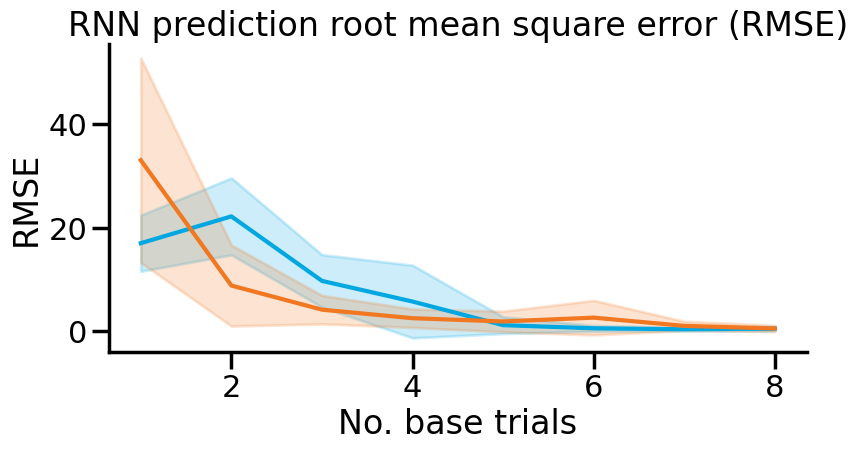

In [11]:
# Plot RMSE vs no. base trials for primitives vs balanced
sns.set_context('poster')
labels = ['Balanced','Primitive']
colors = ['#00A7E1', '#F17720']

fig, ax = plt.subplots(figsize = (9,4))
xpos = np.arange(1, means_p.shape[0]+1)
ax.plot(xpos, means_b, label = labels[0], color=colors[0])
ax.fill_between(xpos, means_b + std_b, means_b - std_b, color=colors[0], alpha=0.2)

ax.plot(xpos, means_p, label = labels[1], color=colors[1])
ax.fill_between(xpos, means_p + std_p, means_p - std_p, color=colors[1], alpha=0.2)


ax.set_xlabel('No. base trials')
ax.set_ylabel('RMSE')
ax.title.set_text('RNN prediction root mean square error (RMSE)')
#plt.legend(loc='upper right')
sns.despine()

# R squared

plot R squared score against number of base training trials for Balanced vs Primitive curriculum

In [12]:
# extract mean and standard devation of the r squared scores for each training set size, for Balances and Primitive curricula
vals = np.empty((0,4))
for i, res_set in enumerate(res):
    set_vals = np.array(extract_r2(res_set)).reshape(-1,4)
    vals = np.vstack([vals, set_vals])

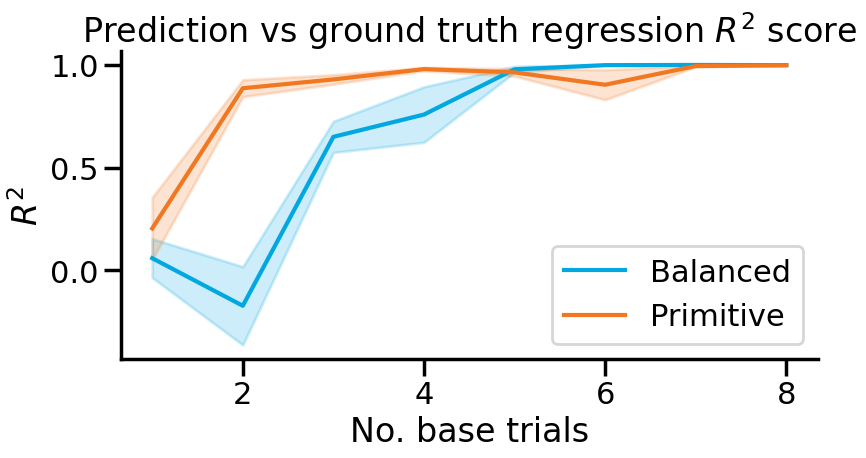

In [13]:
# plot
labels = ['Balanced','Primitive']
colors = ['#00A7E1', '#F17720']
plt.figure(figsize = (9,4))
xpos = np.arange(1, vals.shape[0]+1)
Nn = int(vals.shape[1]/2)
for j in range(Nn):
    plt.plot(xpos, vals[:,j], label = labels[j], color=colors[j])
    plt.fill_between(xpos, vals[:,j] + vals[:,j+Nn], vals[:,j] - vals[:,j+Nn], color=colors[j], alpha=0.2)
plt.legend(loc='lower right')
plt.xlabel('No. base trials')
plt.ylabel('$R^2$')
plt.title('Prediction vs ground truth regression $R^2$ score')
sns.despine()